In [1]:
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio import Entrez
import scipy.stats as stats
import numpy as np
import pandas as pd
from io import StringIO
from Bio.Graphics.KGML_vis import KGMLCanvas
from scipy.stats import chi2_contingency, fisher_exact

from IPython.display import Image

## Task 1: KEGG and gene id mapping

Familiarize yourself with the KEGG Rest interface and how to access it with Biopyhton:

http://www.genome.jp/kegg/rest/keggapi.html

http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

### Subtask 1.1 Extract gene lists for all (mouse) KEGG pathways and store them in a suitable Python data structure

In [2]:
# get all 'pathway's from organism 'mmu' (Mus musculus)

response = kegg_list('pathway', 'mmu').read()

#Read in as csv using the StringIO class
kegg_df = pd.read_csv(StringIO(response), sep = '\t', header = None)

kegg_df.head()

,0,1
0,path:mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (m...
1,path:mmu00020,Citrate cycle (TCA cycle) - Mus musculus (mouse)
2,path:mmu00030,Pentose phosphate pathway - Mus musculus (mouse)
3,path:mmu00040,Pentose and glucuronate interconversions - Mus...
4,path:mmu00051,Fructose and mannose metabolism - Mus musculus...


### Subtask 1.2: Save the KEGG gene sets as a gmt file after you made sure they have the proper gene ids with respect to your DE analysis

hints: 

http://www.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats

In [3]:
# extract pathway IDs from the raw REST response
pathways = [((pathway.split('\t')[0]).split(':'))[-1] for pathway in response.split('\n')[:-1]]

# print the number of pathways and the IDs of the first 10
print('Number of pathways: '+ str(len(pathways)))
pathways[:10]

Number of pathways: 326


['mmu00010',
 'mmu00020',
 'mmu00030',
 'mmu00040',
 'mmu00051',
 'mmu00052',
 'mmu00053',
 'mmu00061',
 'mmu00062',
 'mmu00071']

In [4]:
genelists_pathways = []

for i in pathways:

    geneList = kegg_link('mmu', i).read()
    pathsgenes = pd.read_csv(StringIO(geneList), sep = '\t', header = None)
    genelists_pathways.append(pathsgenes)

len(genelists_pathways)

326

In [5]:
#Connect path names with entrez identifiers
pw_entrez = pd.concat(genelists_pathways)
pw_entrez.columns = ['path', 'entrez']
pw_entrez['entrez'] = pw_entrez['entrez'].str.replace('mmu:', '')

In [6]:
pw_entrez.head()

,path,entrez
0,path:mmu00010,100042025
1,path:mmu00010,103988
2,path:mmu00010,106557
3,path:mmu00010,110695
4,path:mmu00010,11522


In [7]:
#Here stuff didn't work out so well for some reason. Maybe the mac, idk.
#So we used planB and loaded the alternative.rpt file.

rescue_file = pd.read_csv('files/alternative.rpt', sep='\t', index_col=False)
rescue_file.head()


,1. MGI accession id,2. marker type,3. marker symbol,4. marker name,5. genome build,6. Entrez gene id,7. NCBI gene chromosome,8. NCBI gene start,9. NCBI gene end,10. NCBI gene strand,11. Ensembl gene id,12. Ensembl gene chromosome,13. Ensembl gene start,14. Ensembl gene end,15. Ensembl gene strand,16. VEGA gene id,17. VEGA gene chromosome,18. VEGA gene start,19. VEGA gene end,20. VEGA gene strand
0,MGI:87853,Gene,a,nonagouti,GRCm38,50518.0,2,154950204.0,155051012.0,+,ENSMUSG00000027596,2,154791402.0,155051012.0,+,OTTMUSG00000015981,2,154791402.0,155051012.0,+
1,MGI:87854,Gene,Pzp,"PZP, alpha-2-macroglobulin like",GRCm38,11287.0,6,128483567.0,128526720.0,-,ENSMUSG00000030359,6,128483567.0,128526720.0,-,OTTMUSG00000022212,6,128483567.0,128526720.0,-
2,MGI:87859,Gene,Abl1,"c-abl oncogene 1, non-receptor tyrosine kinase",GRCm38,11350.0,2,31688354.0,31807093.0,+,ENSMUSG00000026842,2,31688376.0,31804227.0,+,OTTMUSG00000012077,2,31688376.0,31804227.0,+
3,MGI:87860,Gene,Abl2,v-abl Abelson murine leukemia viral oncogene 2...,GRCm38,11352.0,1,156558171.0,156649619.0,+,ENSMUSG00000026596,1,156558786.0,156649568.0,+,OTTMUSG00000037114,1,156558786.0,156649568.0,+
4,MGI:87862,Gene,Scgb1b27,"secretoglobin, family 1B, member 27",GRCm38,11354.0,7,34021567.0,34022881.0,+,ENSMUSG00000066583,7,34021483.0,34022881.0,+,OTTMUSG00000008372,7,34021483.0,34022881.0,+


In [8]:
#Select the 3rd and 6th and do some transformtion to the dataset
symbol_to_entrez = rescue_file[['3. marker symbol','6. Entrez gene id']]
symbol_to_entrez = symbol_to_entrez.dropna()
symbol_to_entrez.columns = ['symbol', 'entrez']

symbol_to_entrez['entrez']  = symbol_to_entrez['entrez'].apply(int).apply(str)
symbol_to_entrez.head()

,symbol,entrez
0,a,50518
1,Pzp,11287
2,Abl1,11350
3,Abl2,11352
4,Scgb1b27,11354


## Task 2: Gene Set Enrichment

### Subtask 2.1: Read in the csv file you produced during the Differential Expression module, extract a gene list (as a python list of gene symbols) from your favorite multiple correction column (and store it in a variable)

In [9]:
#Read in different expression values file from yesterday
pvalues = pd.read_csv('files/DEanalysis.csv', sep="\t")

In [10]:
gene_list = pvalues[['Gene.1','is_interesting', 'fc']]

gene_list.head()

,Gene.1,is_interesting,fc
0,544988,False,-0.043042
1,100043387,False,-0.083700
2,0610007C21Rik,False,-0.012175
3,0610007L01Rik,False,0.008500
4,0610007P08Rik,False,-0.063438


### Subtask 2.2: Perform gene set enrichment (Fisher's exact test or an hypergeometric test will do for our purposes) with the KEGG gene sets you extracted in Task 1 (you may want to store the results in a pandas dataframe and write them to csv)

hint:

https://genetrail2.bioinf.uni-sb.de/help?topic=set_level_statistics

In [11]:
#Getting a table in the relevant form is a bit of work and done in 2 merging steps

#Perform merge 1
merge1 = gene_list.merge(symbol_to_entrez, left_on='Gene.1', right_on='symbol')
merge1.head()

,Gene.1,is_interesting,fc,symbol,entrez
0,0610009B22Rik,False,-0.056050,0610009B22Rik,66050
1,0610009L18Rik,False,-0.034725,0610009L18Rik,66838
2,0610010F05Rik,False,0.049100,0610010F05Rik,71675
3,0610010K14Rik,False,-0.191400,0610010K14Rik,104457
4,0610012G03Rik,False,-0.067550,0610012G03Rik,106264


In [12]:
#Perform merge 2
merge_all = merge1.merge(pw_entrez, on='entrez')
merge_all.head()

,Gene.1,is_interesting,fc,symbol,entrez,path
0,1300017J02Rik,False,0.10045,1300017J02Rik,71775,path:mmu04066
1,1300017J02Rik,False,0.10045,1300017J02Rik,71775,path:mmu04216
2,1300017J02Rik,False,0.10045,1300017J02Rik,71775,path:mmu04978
3,1700009N14Rik,False,0.01510,1700009N14Rik,75471,path:mmu03008
4,1700009N14Rik,False,0.01510,1700009N14Rik,75471,path:mmu03013


In [13]:
merge_all_gen = merge_all.drop_duplicates('Gene.1')

#Numer of interesting genes 
merge_all_gen.groupby('is_interesting').count()

,Gene.1,fc,symbol,entrez,path
is_interesting,,,,,
False,6763,6763,6763,6763,6763
True,589,589,589,589,589


In [14]:
#Start building the contingency table for the fishers exact test

#In the pathway AND interesting genes
pathwayTrueinterestingTrue = merge_all.groupby('path').is_interesting.sum()
pathwayTrueinterestingTrue.name = "in_int"

df_cont = pd.DataFrame(pathwayTrueinterestingTrue)
df_cont.head()

,in_int
path,
path:mmu00010,8.0
path:mmu00020,1.0
path:mmu00030,0.0
path:mmu00040,5.0
path:mmu00051,2.0


In [15]:
#In the pathway but not interesting = In the pathway - in the pathway AND interesting
firstRow = merge_all.groupby('path').size()
df_cont["in_non"] = firstRow - df_cont['in_int']
df_cont.head()

,in_int,in_non
path,,
path:mmu00010,8.0,53.0
path:mmu00020,1.0,30.0
path:mmu00030,0.0,30.0
path:mmu00040,5.0,19.0
path:mmu00051,2.0,31.0


In [16]:
#Not in the pathway but also interesting = All interesting genes - the interesting genes that in the pathway
firstCol = merge_all.drop_duplicates('symbol').is_interesting.sum()
df_cont['out_int'] = firstCol-df_cont['in_int']
df_cont.head()

,in_int,in_non,out_int
path,,,
path:mmu00010,8.0,53.0,581.0
path:mmu00020,1.0,30.0,588.0
path:mmu00030,0.0,30.0,589.0
path:mmu00040,5.0,19.0,584.0
path:mmu00051,2.0,31.0,587.0


In [17]:
#Add the last column to the dataframe: Not in the pathway and not interesting
total = merge_all.drop_duplicates('symbol').shape[0]
df_cont['out_non'] = total -df_cont.sum(axis=1)
df_cont.head()

,in_int,in_non,out_int,out_non
path,,,,
path:mmu00010,8.0,53.0,581.0,6710.0
path:mmu00020,1.0,30.0,588.0,6733.0
path:mmu00030,0.0,30.0,589.0,6733.0
path:mmu00040,5.0,19.0,584.0,6744.0
path:mmu00051,2.0,31.0,587.0,6732.0


In [18]:
#Do the fishers test
fishers_pvalues = df_cont.apply(lambda x: fisher_exact([[x.in_int, x.in_non], [x.out_int, x.out_non]])[1], axis=1)

### Subtask 2.3: Extract a list of significantly (at 0.05 significance) enriched KEGG pathways

In [19]:
#Significance threshold = 0.05
signi = fishers_pvalues[fishers_pvalues < 0.05]
print('Number of significant enriched pathways: '+ str(len(signi)))
signi

Number of significant enriched pathways: 48


path
path:mmu00040    3.851462e-02
path:mmu00053    4.384410e-04
path:mmu00140    3.554827e-08
path:mmu00380    1.255294e-02
path:mmu00512    3.256322e-02
path:mmu00590    7.296881e-03
path:mmu00591    3.458501e-03
path:mmu00650    1.782872e-02
path:mmu00830    1.312111e-06
path:mmu00970    4.645079e-02
path:mmu00980    3.923741e-02
path:mmu00982    1.241812e-02
path:mmu01230    4.342856e-02
path:mmu01521    2.548882e-03
path:mmu01522    9.738209e-03
path:mmu03008    4.342856e-02
path:mmu03010    1.259797e-02
path:mmu03013    6.807587e-04
path:mmu03040    2.081606e-03
path:mmu03320    2.949451e-03
path:mmu04014    2.400040e-02
path:mmu04060    2.005094e-02
path:mmu04080    1.872587e-02
path:mmu04120    2.750977e-03
path:mmu04140    5.766043e-03
path:mmu04141    2.366270e-02
path:mmu04330    3.095768e-02
path:mmu04514    4.441680e-02
path:mmu04612    1.717841e-02
path:mmu04714    1.610105e-02
path:mmu04725    1.157325e-02
path:mmu04740    3.926513e-08
path:mmu04914    4.556483e-02
path:

## Task 3: KEGG map visualization

#### hint:

http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

#### remark:

In real life you may want to use the R-based tool pathview: https://bioconductor.org/packages/release/bioc/html/pathview.html (if you insist you can also try to use r2py for using pathview from Python during the practical)

For Python (in addition to the Biopyhton module) https://github.com/idekerlab/py2cytoscape in combination with https://github.com/idekerlab/KEGGscape may be another alternative (in the future)

Generally speaking, it is always a good idea to pay attention also to other pathway databases like Reactome or WikiPathways ...

### Subtask 3.1: Pick some significantly enriched KEGG pathways of your choice from 2.3 and visualize them

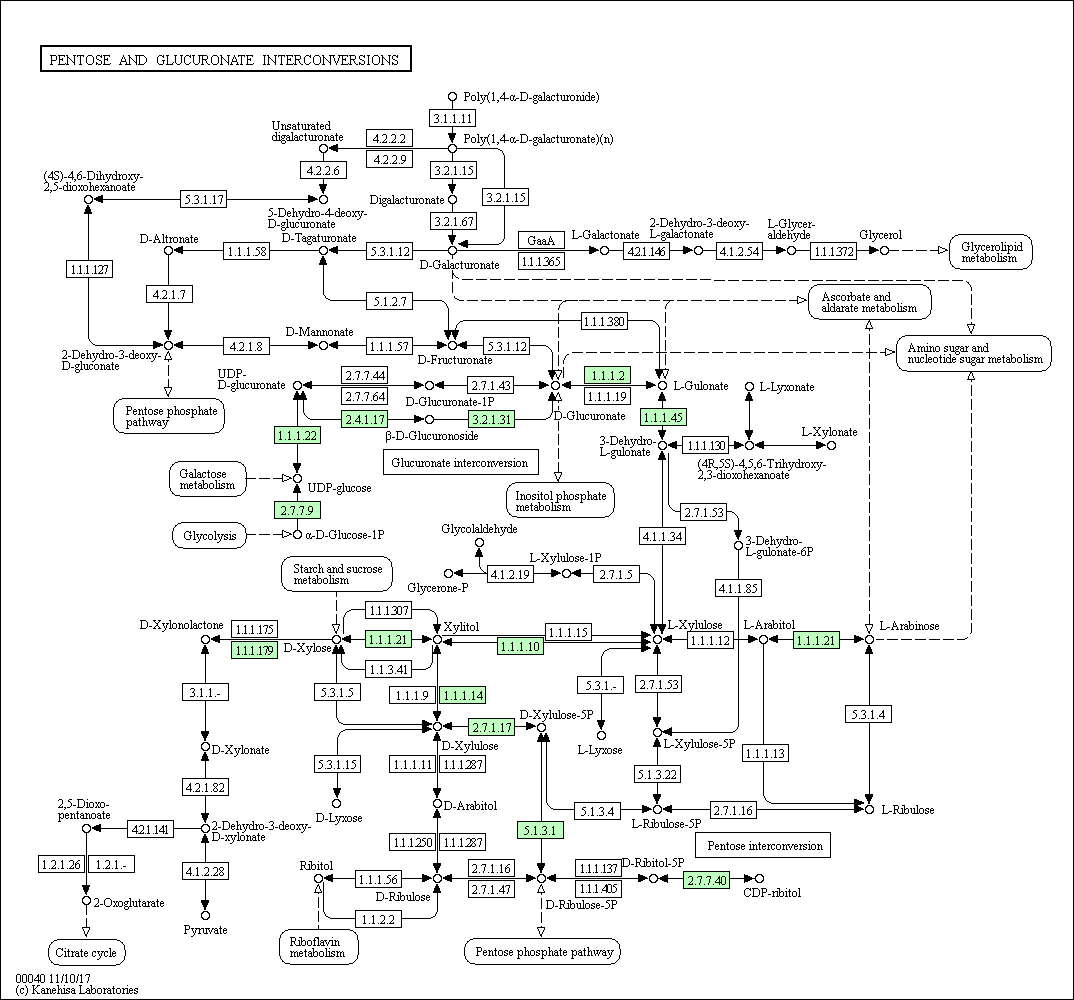

In [20]:
#Straight forward: Chose the first pathway in the list
Image(kegg_get("path:mmu00040", "image").read())

### Subtask 3.2: Define a a suitable binary color scheme respresenting the fact whether a gene is significantly expressed or not

hint: 

http://www.rapidtables.com/web/color/RGB_Color.htm

In [21]:
#Not in pathway: White
#Expressed in pw but not significant: Light Green
#Significant with possitive logchange: Blue
#Significant with negative logchange: Red

pathway = KGML_parser.read(kegg_get('mmu00040', "kgml"))

to_color_blue = []
to_color_red = []
to_color_green = []
counter = 0

# This determines which genes are significant or if there is even a gene available
for gene in pathway.genes[0:14]:
    gene_list = gene.name.split(' ')
    
    for g in gene_list:
        counter += 1
        genes = merge_all[merge_all['entrez'].str.contains(g[4:])] #Cut the string
        correct_path = genes[genes['path'].str.contains('mmu00040')]
        
        # if in path and also significant:
        if correct_path['is_interesting'].values:
            
            # + negative logchange:
            if(correct_path['fc'].values < 0):
                to_color_red.append(g)
            # + possitive logchange:
            else:
                to_color_blue.append(g)
            
        # if in path but not significant append to green list    
        else: 
            to_color_green.append(g)
            
        #if not in path and also not significant dont' touch it so it stays white
            
    # color the genes according to lists
    for graphic in gene.graphics:
        for g in gene_list:
            if g in to_color_green:
                graphic.bgcolor = "#99FF33"
            elif g in to_color_red:
                graphic.bgcolor = "#FF0000"   
            elif g in to_color_blue:
                graphic.bgcolor = "#0080FF"   

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


### Subtask 3.3: Visualize the pathway(s) from 3.1 in such a way that the included genes have the corresponding color from 3.2 ( you may need to define a suitable mapping from single genes to what is actually shown in the pathway map...)

In [22]:
# create pdf
canvas = KGMLCanvas(pathway)
canvas.draw("files/pathway.pdf")

canvas.import_imagemap = True
canvas.draw("files/pathway.pdf")